<a href="https://colab.research.google.com/github/casjunior93/projeto-integrador-iv/blob/main/Etl_e_cria%C3%A7%C3%A3o_dos_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas fundamentais

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import scipy.stats as stats
import urllib.request, json 
from pandas.io.json import json_normalize

#Scikit-Learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

#Configura o pandas para não exibir resultados em notação científica
pd.options.display.float_format = '{:.2f}'.format

#Semente aleatória do Numpy
np.random.seed(42)

#Data local
import locale
# Colab não suporta
#locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

# URL base da api de dados

In [2]:
url_base = 'https://univesp-analytics.vercel.app/api/get'

# Lendo Json com Pandas

In [3]:
%%time
pagina = 1
limite = 10000
fim_iteracao_api = False
df_dados_api_original = pd.DataFrame([])

print(f'Início das requisições')
while fim_iteracao_api == False:
  with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df = pd.DataFrame(json_normalize(data))
    print('.', end='')
    if len(data) == 0:
      print('')
      print(f'Fim. Total de {pagina - 1} páginas e {df_dados_api_original.shape[0]} registros.')
      fim_iteracao_api = True
    else:
      if pagina % 100 == 0:
        print(f'Fim leitura página {pagina}')
      pagina += 1
      df_dados_api_original = pd.concat([df_dados_api_original, df], ignore_index = True)

Início das requisições
.........
Fim. Total de 8 páginas e 79374 registros.
CPU times: user 1.8 s, sys: 118 ms, total: 1.92 s
Wall time: 20.5 s


In [4]:
%%time
''' with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df_dados_api_original = pd.DataFrame(json_normalize(data)) '''

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


" with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:\n    data = json.loads(url.read().decode())\n    df_dados_api_original = pd.DataFrame(json_normalize(data)) "

Cópia dos dados da api

In [5]:
df_dados_api = df_dados_api_original.copy()

Dimensão dos dados - Linhas, colunas

In [6]:
df_dados_api.shape

(79374, 9)

# Visualizando dados originais

Mudando ordenação dos dados

In [7]:
df_dados_api.sort_index(ascending=False, inplace=True, ignore_index=True)

Cinco primeiros registros do dataframe - Em ordem da disposição na API

In [8]:
df_dados_api.head()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
0,63fea0720dd58484fc266c80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.00
1,63ffdbb91a4eb0dfdd6a11a7,2,3,teste,NaN,2023-03-01T23:11:53.036Z,01/03/2023,20:11:53,NaN
2,63ffdbde1a4eb0dfdd6a11a8,10,10,teste,NaN,2023-03-01T23:12:30.063Z,01/03/2023,20:12:30,NaN
3,63ffdea6722bef68acc5bb72,333,333,teste,NaN,2023-03-01T23:24:21.438Z,01/03/2023,23:24:21,NaN
4,63ffed2b38c8784e07b788f2,15,15,teste,NaN,01/03/2023 21:26:19,01/03/2023,21:26:19,NaN


Cinco últimos registros do dataframe

In [9]:
df_dados_api.tail()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
79369,644d105c4d3f6a6e7e680526,21.10,74.10,teste,semAr,"29/04/2023, 09:41:00","29/04/2023,",09:41:00,NaN
79370,644d113f4d3f6a6e7e680527,24.60,59.70,teste,comAr,"29/04/2023, 09:44:47","29/04/2023,",09:44:47,NaN
79371,644d118a4d3f6a6e7e680528,21.20,74.30,teste,semAr,"29/04/2023, 09:46:02","29/04/2023,",09:46:02,NaN
79372,644d126d4d3f6a6e7e680529,24.60,60.10,teste,comAr,"29/04/2023, 09:49:49","29/04/2023,",09:49:49,NaN
79373,644d12b84d3f6a6e7e68052a,21.30,74.50,teste,semAr,"29/04/2023, 09:51:04","29/04/2023,",09:51:04,NaN


Verificando dados nulos

In [10]:
df_dados_api.isnull().sum()

_id                 0
temp_ar             3
umid_ar             3
type                1
local           55412
time.time_js        1
time.data           1
time.hora           1
teste           79373
dtype: int64

Excluindo colunas desnecessárias

In [11]:
del df_dados_api['teste']
del df_dados_api['_id']
del df_dados_api['type']
del df_dados_api['time.time_js']
df_dados_api.head()

,temp_ar,umid_ar,local,time.data,time.hora
0,NaN,NaN,NaN,NaN,NaN
1,2,3,NaN,01/03/2023,20:11:53
2,10,10,NaN,01/03/2023,20:12:30
3,333,333,NaN,01/03/2023,23:24:21
4,15,15,NaN,01/03/2023,21:26:19


Tratando nova coluna local

In [12]:
df_dados_api.local.value_counts()

semAr    20526
comAr     3432
API          2
teste        1
123          1
Name: local, dtype: int64

In [13]:
values = {"local": "comAr"}
df_dados_api.fillna(value=values, inplace=True)

In [14]:
df_dados_api.local.value_counts()

comAr    58844
semAr    20526
API          2
teste        1
123          1
Name: local, dtype: int64

Limpeza de dados nulos

In [15]:
df_dados_api.dropna(inplace = True)
df_dados_api.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
dtype: int64

Removendo dados duplicados

In [16]:
df_dados_api.shape

(79371, 5)

In [17]:
df_dados_api.drop_duplicates(inplace=True, ignore_index=True)
df_dados_api.shape

(79371, 5)

# Comportamento das variáveis

Tipo dos dados e convertendo strings para float

In [18]:
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79371 entries, 0 to 79370
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   temp_ar    79371 non-null  object
 1   umid_ar    79371 non-null  object
 2   local      79371 non-null  object
 3   time.data  79371 non-null  object
 4   time.hora  79371 non-null  object
dtypes: object(5)
memory usage: 3.0+ MB


In [19]:
df_dados_api = df_dados_api.astype({'temp_ar':'float', 'umid_ar':'float'})
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79371 entries, 0 to 79370
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_ar    79371 non-null  float64
 1   umid_ar    79371 non-null  float64
 2   local      79371 non-null  object 
 3   time.data  79371 non-null  object 
 4   time.hora  79371 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.0+ MB


Análise descritiva dos dados

In [20]:
df_dados_api.describe()

,temp_ar,umid_ar
count,79371.00,79371.00
mean,25.66,59.67
std,2.63,8.44
min,2.00,3.00
25%,25.30,54.00
50%,26.00,58.00
75%,26.50,64.00
max,333.00,333.00


Opa, parece haver outliers.

Separando os conjuntos de dados do ambiente com ar condicionado e sem ar condicionado.

In [21]:
df_comAr = df_dados_api.loc[df_dados_api['local'] == 'comAr']
df_semAr = df_dados_api.loc[df_dados_api['local'] == 'semAr']

Verificando outliers

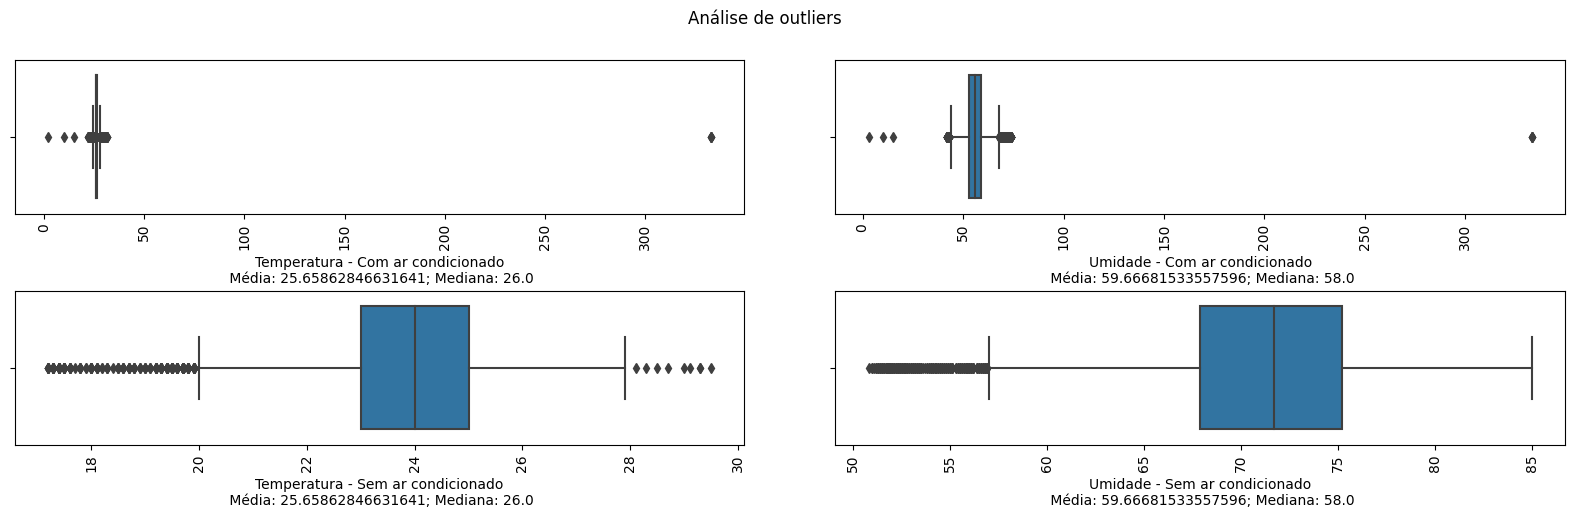

CPU times: user 700 ms, sys: 66 ms, total: 766 ms
Wall time: 804 ms


In [22]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Excluindo outliers superiores do conjunto com ar condicionado

In [23]:
def limites_outliers(coluna):
  Q1 = coluna.quantile(.25)
  Q3 = coluna.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  return limite_inferior, limite_superior

In [24]:
limite_inferior_temp_ar, limite_superior_temp_ar = limites_outliers(df_comAr['temp_ar'])
limite_inferior_umid_ar, limite_superior_umid_ar = limites_outliers(df_comAr['umid_ar'])

Visualizando registros considerados como outliers

In [25]:
selecao_temp_ar = (df_comAr['temp_ar'] > limite_superior_temp_ar) | (df_comAr['umid_ar'] > limite_superior_umid_ar)
temp_ar1 = df_comAr[selecao_temp_ar]
temp_ar1.describe()

,temp_ar,umid_ar
count,2122.00,2122.00
mean,28.21,54.54
std,13.34,14.87
min,21.90,43.00
25%,28.00,48.00
50%,28.20,50.00
75%,28.40,55.00
max,333.00,333.00


In [26]:
selecao_temp_ar2 = (temp_ar1['temp_ar'] < 333.0) | (temp_ar1['umid_ar'] < 333.0)
temp_ar2 = temp_ar1[selecao_temp_ar2]
temp_ar2.describe()

,temp_ar,umid_ar
count,2118.00,2118.00
mean,27.63,54.01
std,1.55,8.65
min,21.90,43.00
25%,28.00,48.00
50%,28.20,50.00
75%,28.40,55.00
max,31.20,74.00


Removendo dados com valor de temp_ar e umid_ar iguais à 333,0. Não vou remover valores menores que este porque são valores possíveis de acontecer.

In [27]:
selecao_temp_ar = (df_comAr['temp_ar'] <= 31.20) & (df_comAr['umid_ar'] <= 74)
df_comAr = df_comAr[selecao_temp_ar]

Revendo boxplots

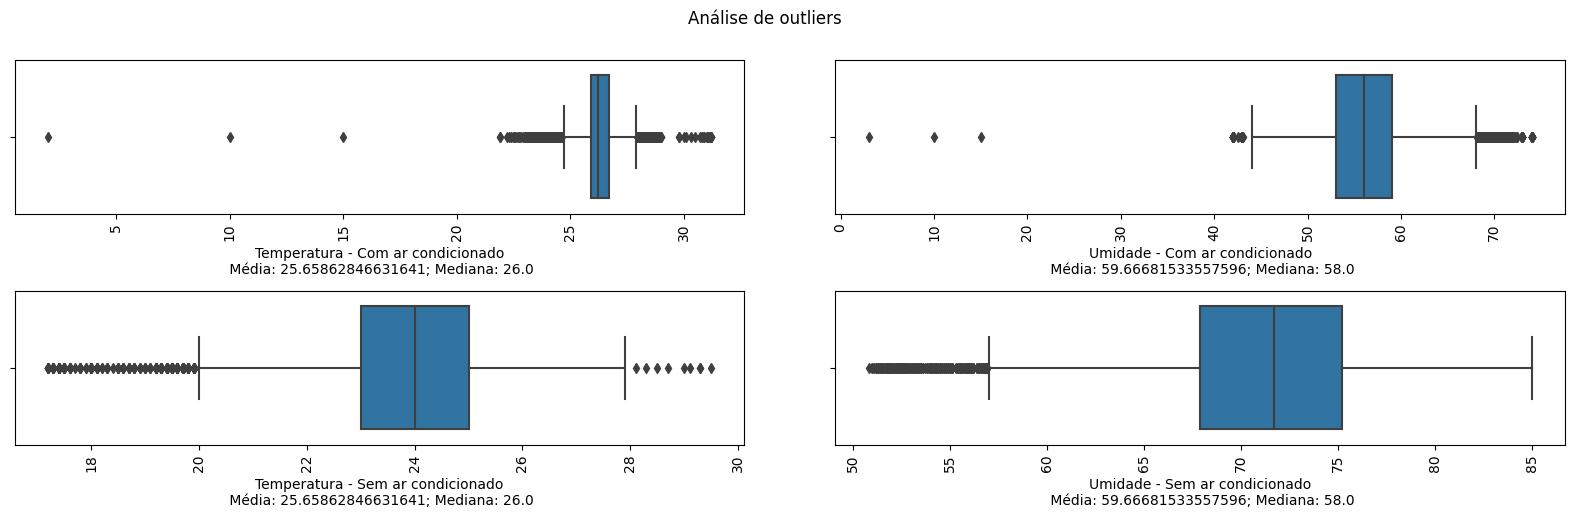

In [28]:
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Agora as curvas de densidade das variáveis

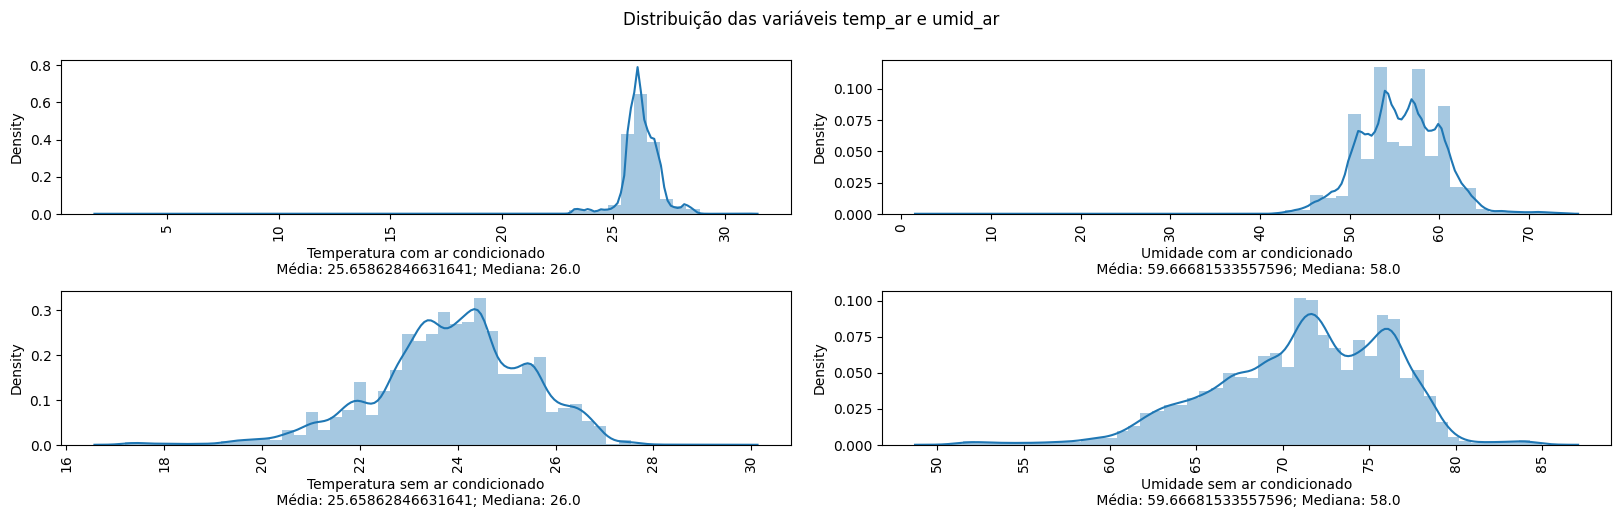

CPU times: user 2.31 s, sys: 547 ms, total: 2.86 s
Wall time: 2.63 s


In [29]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Distribuição das variáveis temp_ar e umid_ar')

#Temperatura - distplot
sns.distplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura - distplot
sns.distplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Testando se as distruições são normais

In [30]:
%%time
stat_temp_comar,p_temp_comarar = stats.shapiro(df_comAr['temp_ar'].to_numpy())
stat_umid_comarar,p_umid_comarar = stats.shapiro(df_comAr['umid_ar'].to_numpy())

stat_temp_semar,p_temp_semar = stats.shapiro(df_semAr['temp_ar'].to_numpy())
stat_umid_semar,p_umid_semar = stats.shapiro(df_semAr['umid_ar'].to_numpy())

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 15.9 ms


In [31]:
print(f'p-value temp_ar com ar condicionado: {p_temp_comarar:.5f}')
print(f'p-value umid_ar com ar condicionado: {p_umid_comarar:.5f}')
print(f'p-value temp_ar sem ar condicionado: {p_temp_semar:.5f}')
print(f'p-value umid_ar sem ar condicionado: {p_umid_semar:.5f}')

p-value temp_ar com ar condicionado: 0.00000
p-value umid_ar com ar condicionado: 0.00000
p-value temp_ar sem ar condicionado: 0.00000
p-value umid_ar sem ar condicionado: 0.00000


Com os p_values < 0.5, logo curvas não normais.

# Tratando data

Copiando dataframes para uma nova variável

In [32]:
dados_projeto_comar = df_comAr.copy()
dados_projeto_semar = df_semAr.copy()

Removendo virgula de time.data e concatenando com time.hora para gerar data no formato datetime

In [33]:
def converte_data_portugues_para_ingles(df):
  return datetime.strptime(df['time.data'], "%d/%m/%Y").strftime("%Y-%m-%d");

In [34]:
dados_projeto_comar['time.data'] = dados_projeto_comar['time.data'].str.replace(',','')
dados_projeto_comar['time.data'] = dados_projeto_comar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_comar['data'] = dados_projeto_comar['time.data'] + ' ' + dados_projeto_comar['time.hora']
dados_projeto_comar['data'] = dados_projeto_comar['data'].astype('datetime64[ns]')

dados_projeto_semar['time.data'] = dados_projeto_semar['time.data'].str.replace(',','')
dados_projeto_semar['time.data'] = dados_projeto_semar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_semar['data'] = dados_projeto_semar['time.data'] + ' ' + dados_projeto_semar['time.hora']
dados_projeto_semar['data'] = dados_projeto_semar['data'].astype('datetime64[ns]')

In [35]:
dados_projeto_semar.tail()

,temp_ar,umid_ar,local,time.data,time.hora,data
79362,20.90,74.70,semAr,2023-04-29,09:30:56,2023-04-29 09:30:56
79364,21.00,74.30,semAr,2023-04-29,09:35:58,2023-04-29 09:35:58
79366,21.10,74.10,semAr,2023-04-29,09:41:00,2023-04-29 09:41:00
79368,21.20,74.30,semAr,2023-04-29,09:46:02,2023-04-29 09:46:02
79370,21.30,74.50,semAr,2023-04-29,09:51:04,2023-04-29 09:51:04


Verificando nulos novamente

In [36]:
dados_projeto_semar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

In [37]:
dados_projeto_comar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

Deletando colunas que não vamos usar mais

In [38]:
del dados_projeto_semar['time.data']
del dados_projeto_semar['time.hora']
del dados_projeto_semar['local']

del dados_projeto_comar['time.data']
del dados_projeto_comar['time.hora']
del dados_projeto_comar['local']

# Filtro por período a partir do dia 04/03/2023

In [39]:
filtro = (dados_projeto_comar.data >= '2023-03-04 00:00:00') & (dados_projeto_comar.data < '2023-04-29 00:00:00')
serie_comar = dados_projeto_comar.loc[filtro]
serie_comar.describe()

,temp_ar,umid_ar
count,58219.00,58219.00
mean,26.25,55.64
std,0.78,4.39
min,21.90,42.00
25%,25.90,53.00
50%,26.20,56.00
75%,26.70,59.00
max,29.00,74.00


In [40]:
filtro2 = (dados_projeto_semar.data >= '2023-03-04 00:00:00') & (dados_projeto_semar.data <= '2023-04-26 00:00:00')
serie_semar = dados_projeto_semar.loc[filtro2]
serie_semar.describe()

,temp_ar,umid_ar
count,19558.00,19558.00
mean,23.97,71.11
std,1.50,5.07
min,17.20,50.80
25%,23.10,67.80
50%,24.00,71.60
75%,25.00,75.10
max,29.50,85.00


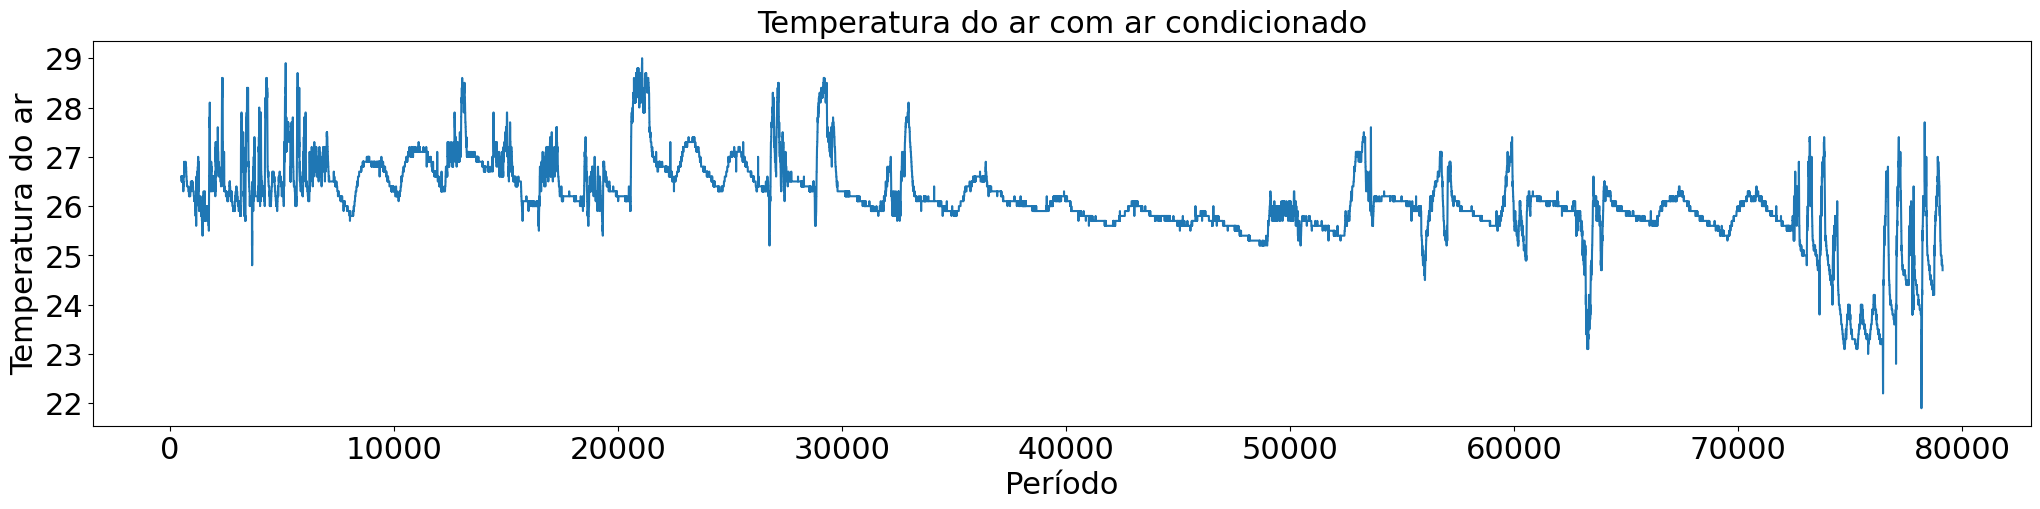

CPU times: user 580 ms, sys: 126 ms, total: 706 ms
Wall time: 589 ms


In [41]:
%%time
plt.figure(figsize=(25,5))
serie_comar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar com ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

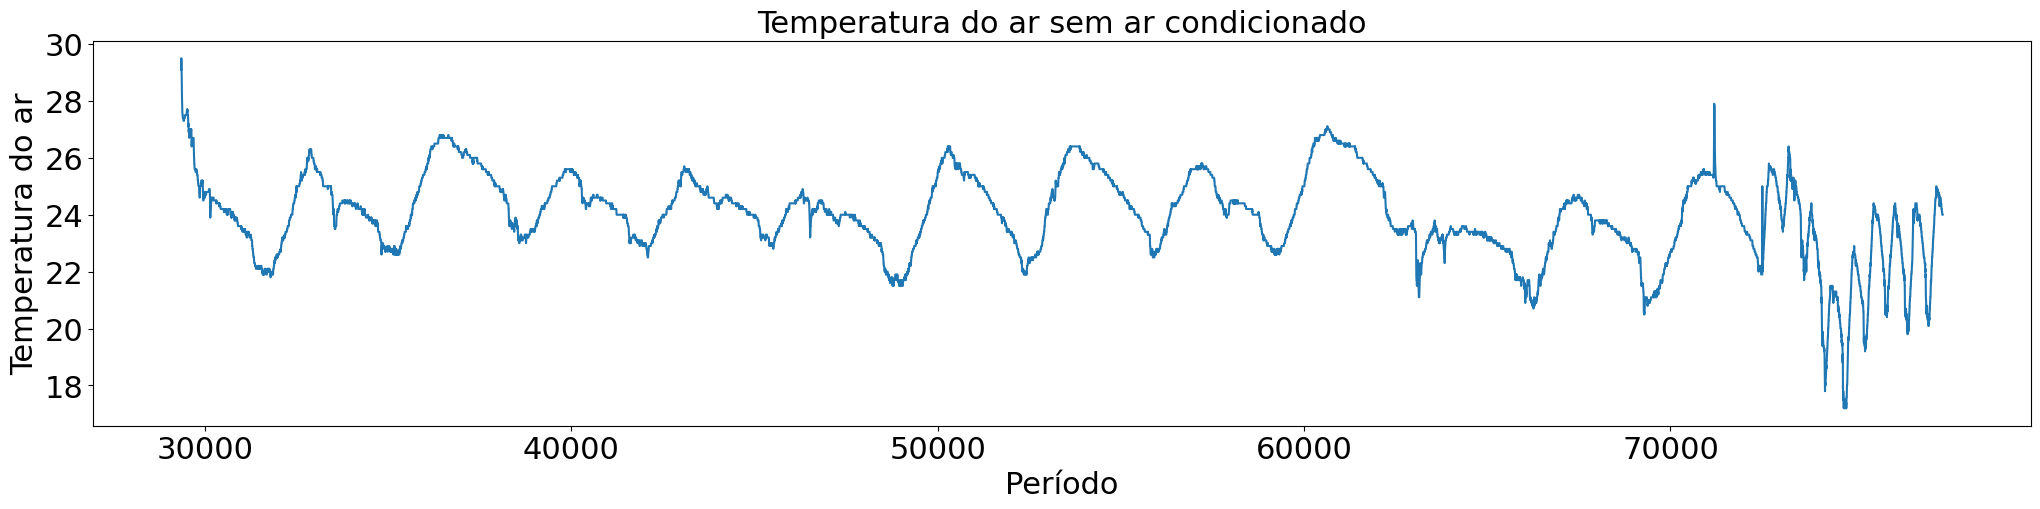

CPU times: user 495 ms, sys: 105 ms, total: 600 ms
Wall time: 516 ms


In [42]:
%%time
plt.figure(figsize=(25,5))
serie_semar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar sem ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

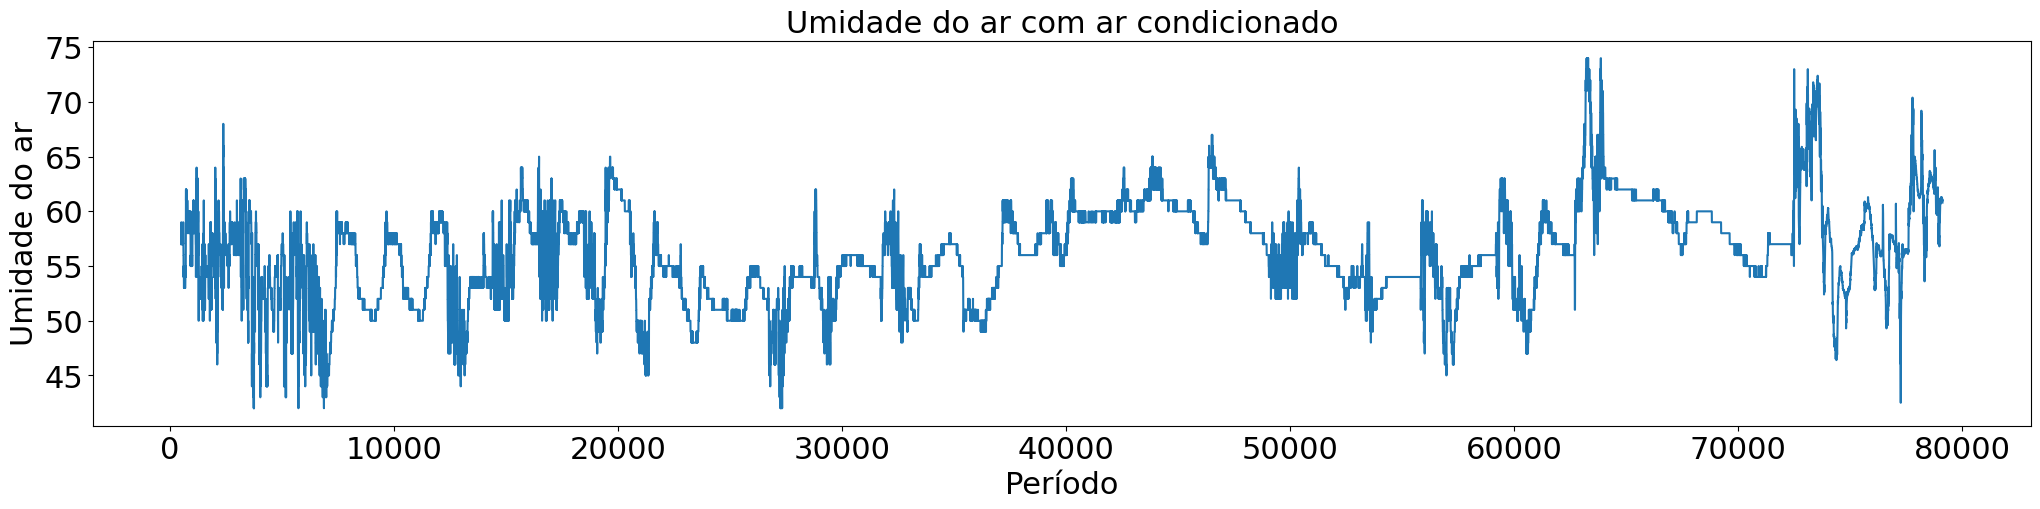

CPU times: user 602 ms, sys: 106 ms, total: 707 ms
Wall time: 612 ms


In [43]:
%%time
plt.figure(figsize=(25,5))
serie_comar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar com ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

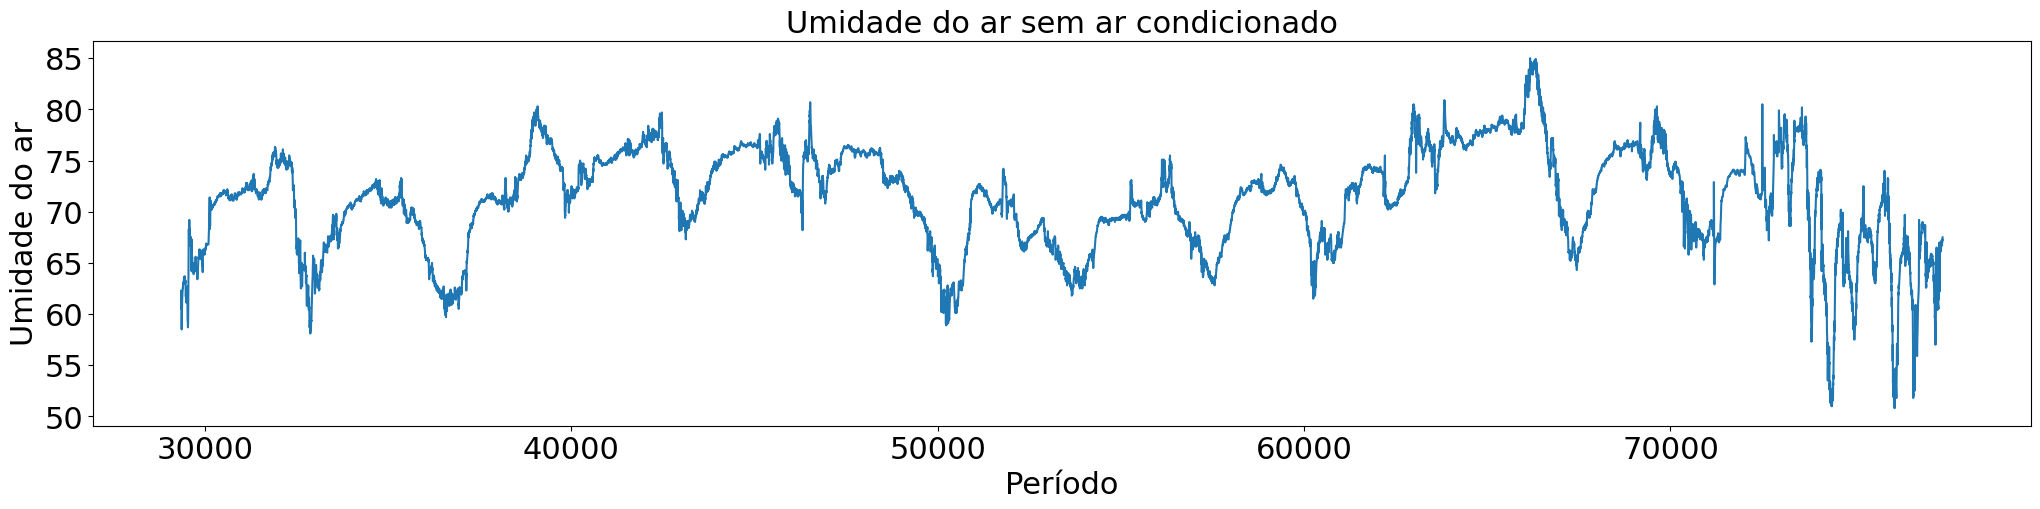

CPU times: user 523 ms, sys: 117 ms, total: 640 ms
Wall time: 526 ms


In [44]:
%%time
plt.figure(figsize=(25,5))
serie_semar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar sem ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

# Agrupando dados a cada t minuto(s) utilizando a média

Vamos tentar reduzir o ruído.

Definindo os minutos

In [45]:
minutos = 60

Setando a data como index

In [46]:
serie_comar.set_index('data', inplace=True)
serie_semar.set_index('data', inplace=True)

In [47]:
serie_comar.head(2)

,temp_ar,umid_ar
data,,
2023-03-04 00:04:12,26.60,57.00
2023-03-04 00:09:14,26.60,58.00


Agrupando os valores de data para cada t minuto(s) pela média

In [48]:
%%time
dados_agrupados_minutos_comar = serie_comar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_comar.head(2)

CPU times: user 14 ms, sys: 999 µs, total: 14.9 ms
Wall time: 21.3 ms


,temp_ar,umid_ar
data,,
2023-03-04 00:00:00,26.60,57.58
2023-03-04 01:00:00,26.59,57.82


In [49]:
%%time
dados_agrupados_minutos_semar = serie_semar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_semar.head(2)

CPU times: user 5.51 ms, sys: 0 ns, total: 5.51 ms
Wall time: 6.47 ms


,temp_ar,umid_ar
data,,
2023-04-04 15:00:00,27.68,62.30
2023-04-04 16:00:00,27.14,64.92


Tamanho do conjunto gerado

In [50]:
dados_agrupados_minutos_comar.shape

(1344, 2)

In [51]:
dados_agrupados_minutos_semar.shape

(513, 2)

Verificando nulos

In [52]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    5
umid_ar    5
dtype: int64

In [53]:
dados_agrupados_minutos_semar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

Preenchendo nulos com os valores anteriores

In [54]:
dados_agrupados_minutos_comar.fillna(method="ffill", inplace = True)

Verificando novamente os nulos

In [55]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

# Gráficos

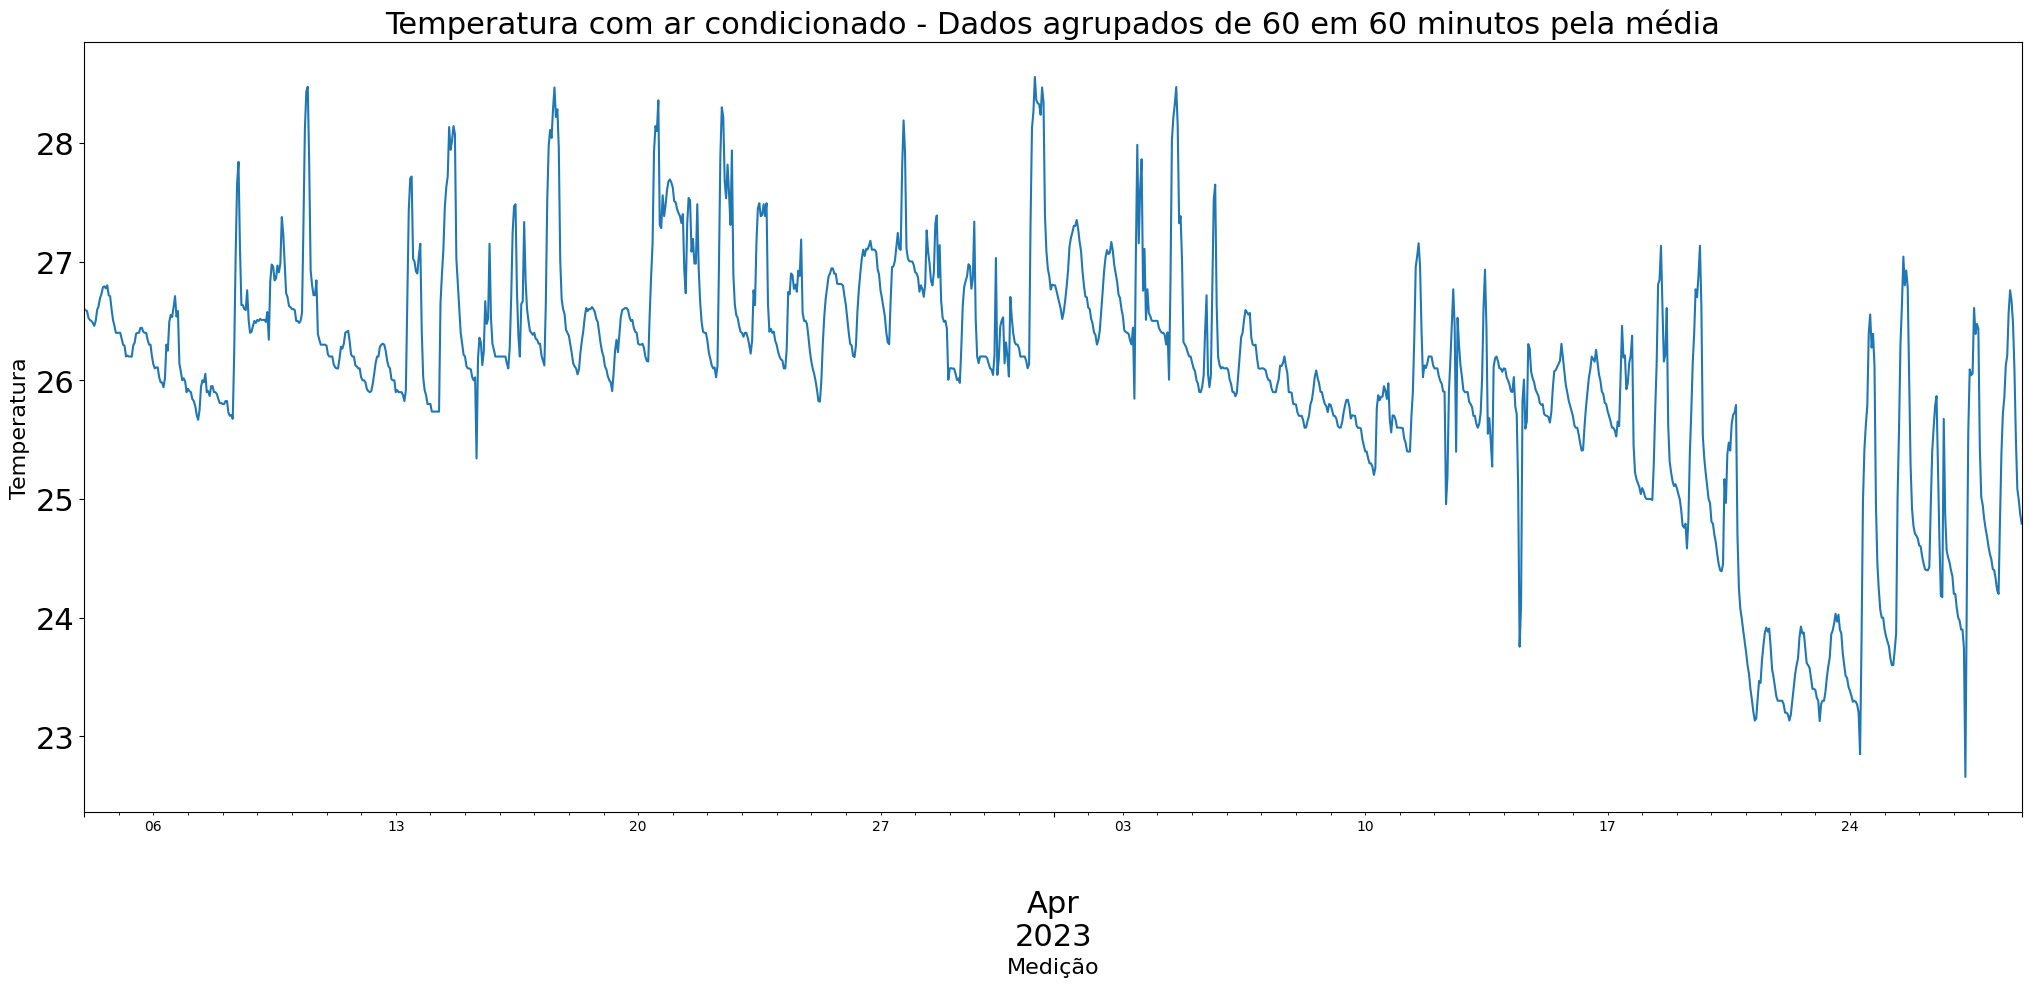

CPU times: user 1.01 s, sys: 115 ms, total: 1.12 s
Wall time: 1.02 s


In [56]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

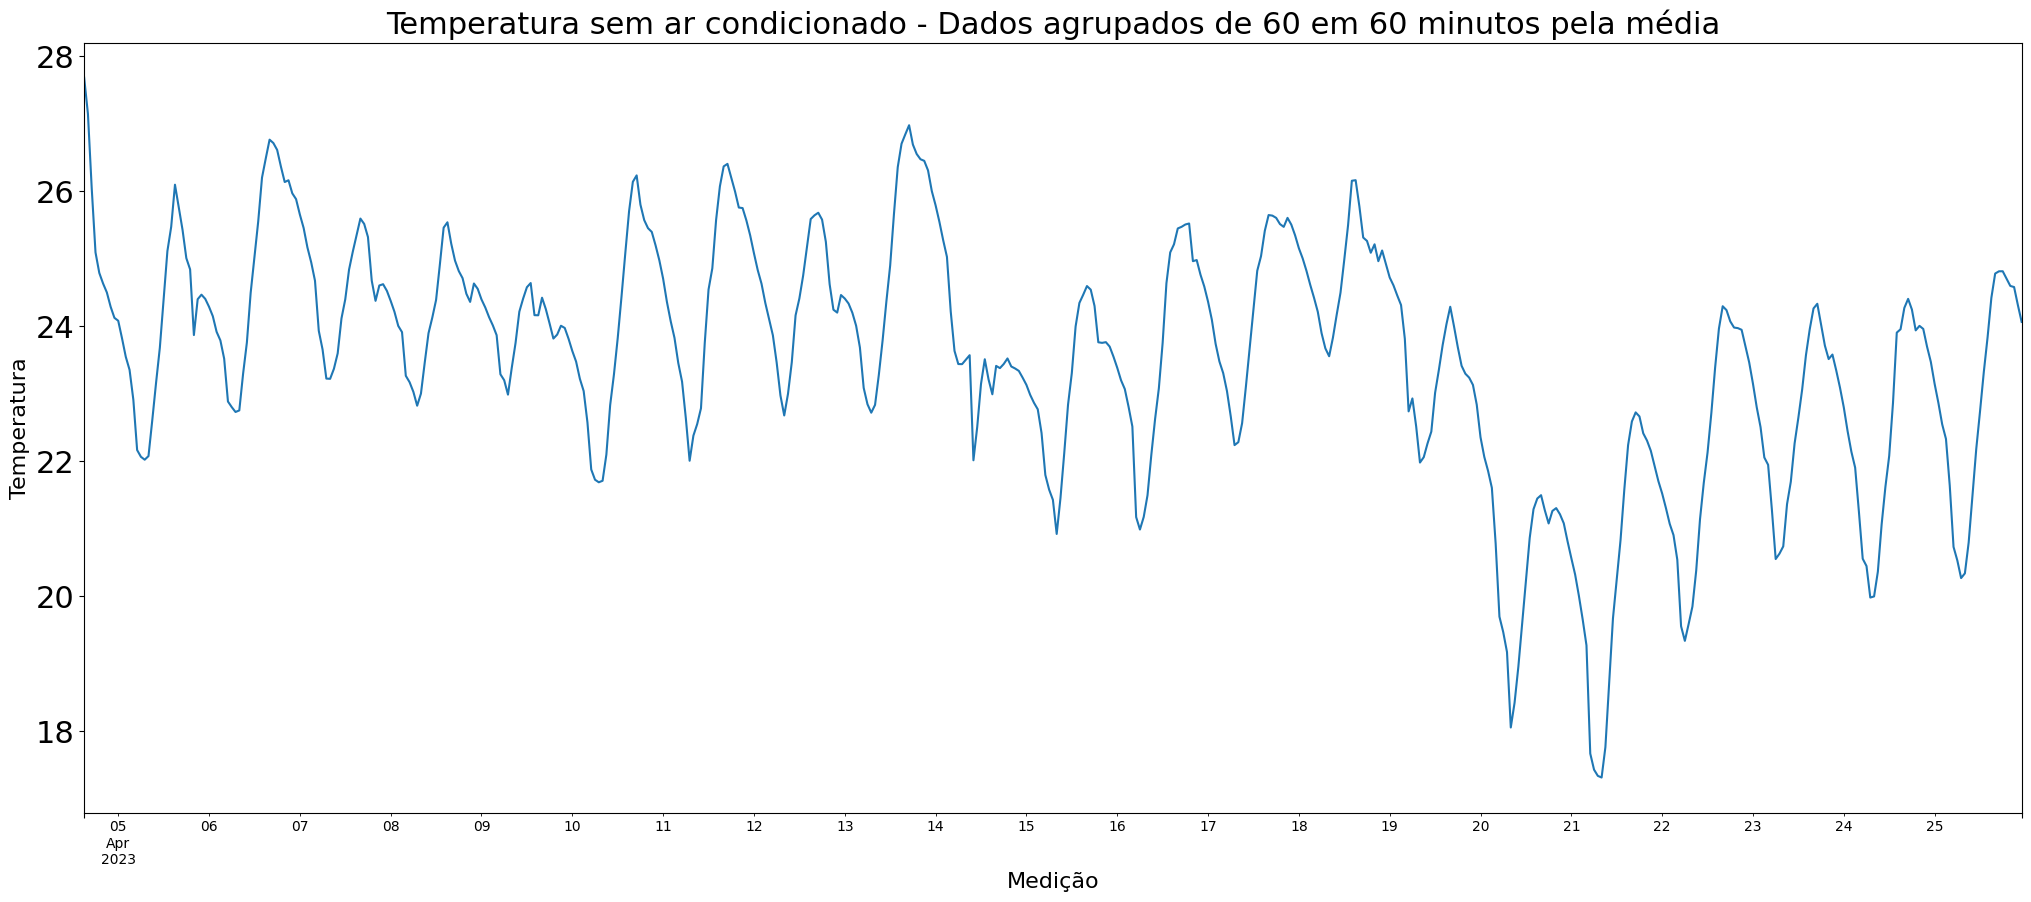

CPU times: user 789 ms, sys: 126 ms, total: 914 ms
Wall time: 826 ms


In [57]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

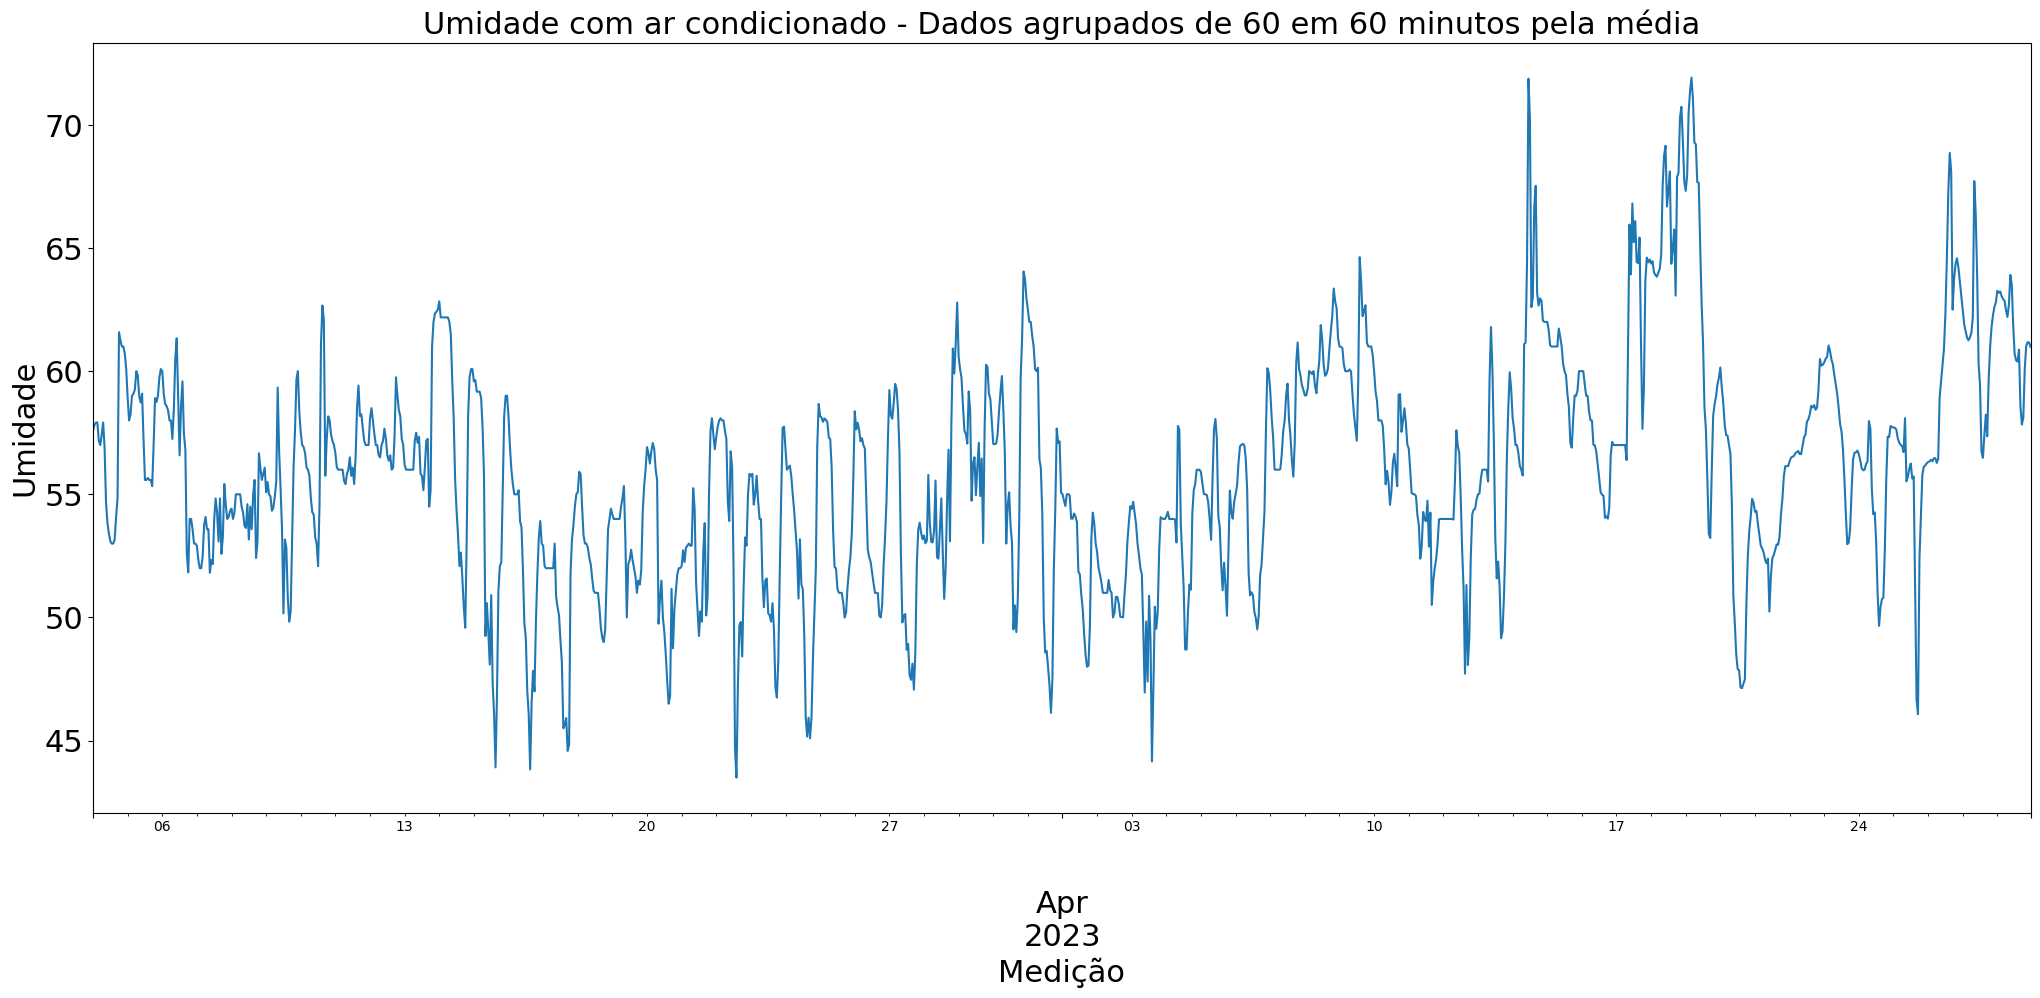

CPU times: user 992 ms, sys: 114 ms, total: 1.11 s
Wall time: 1.01 s


In [58]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

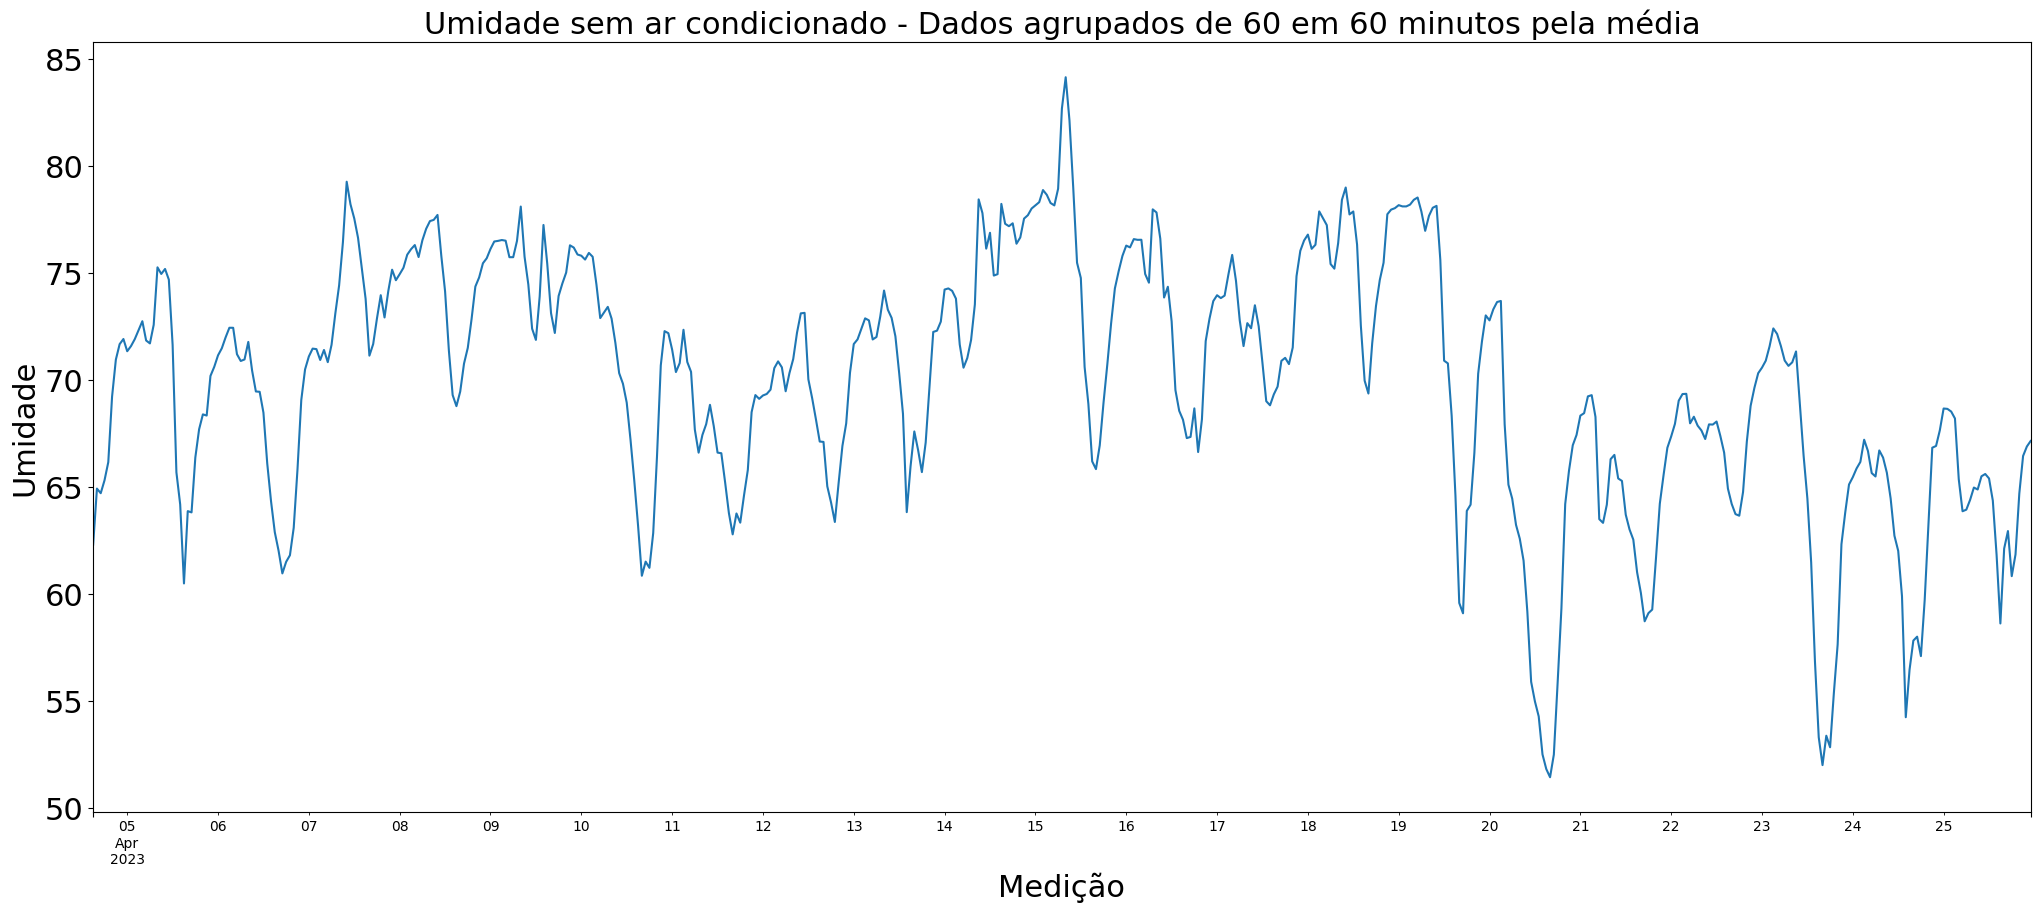

CPU times: user 832 ms, sys: 99.2 ms, total: 931 ms
Wall time: 847 ms


In [59]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

# Suavização com média móvel e rolling

In [60]:
dados_agrupados_minutos_comar_cp = dados_agrupados_minutos_comar.copy()
dados_agrupados_minutos_semar_cp = dados_agrupados_minutos_semar.copy()

In [61]:
''' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp
dados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '''

' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp\ndados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '

In [62]:
dados_agrupados_minutos_comar['media_24_horas_temp_ar'] = dados_agrupados_minutos_comar.temp_ar.rolling(24).mean()
dados_agrupados_minutos_comar['media_24_horas_umid_ar'] = dados_agrupados_minutos_comar.umid_ar.rolling(24).mean()

dados_agrupados_minutos_semar['media_24_horas_temp_ar'] = dados_agrupados_minutos_semar.temp_ar.rolling(24).mean()
dados_agrupados_minutos_semar['media_24_horas_umid_ar'] = dados_agrupados_minutos_semar.umid_ar.rolling(24).mean()

In [63]:
dados_agrupados_minutos_comar.head(24)

,temp_ar,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar
data,,,,
2023-03-04 00:00:00,26.60,57.58,NaN,NaN
2023-03-04 01:00:00,26.59,57.82,NaN,NaN
2023-03-04 02:00:00,26.58,57.92,NaN,NaN
2023-03-04 03:00:00,26.53,57.92,NaN,NaN
2023-03-04 04:00:00,26.51,57.17,NaN,NaN
2023-03-04 05:00:00,26.50,57.00,NaN,NaN
2023-03-04 06:00:00,26.48,57.42,NaN,NaN
2023-03-04 07:00:00,26.46,57.92,NaN,NaN
2023-03-04 08:00:00,26.50,56.92,NaN,NaN


Comparando a média móvel com os dados

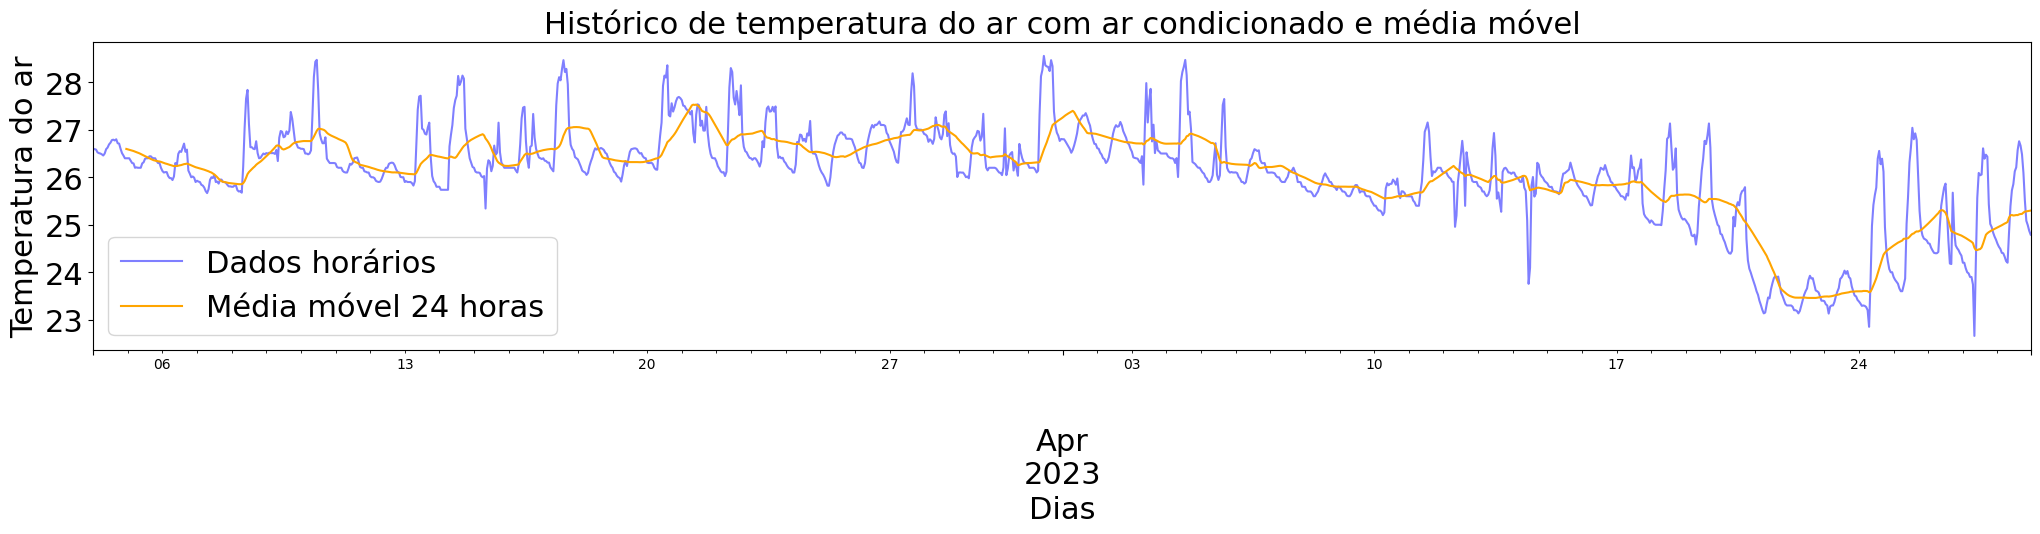

CPU times: user 895 ms, sys: 114 ms, total: 1.01 s
Wall time: 920 ms


In [64]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

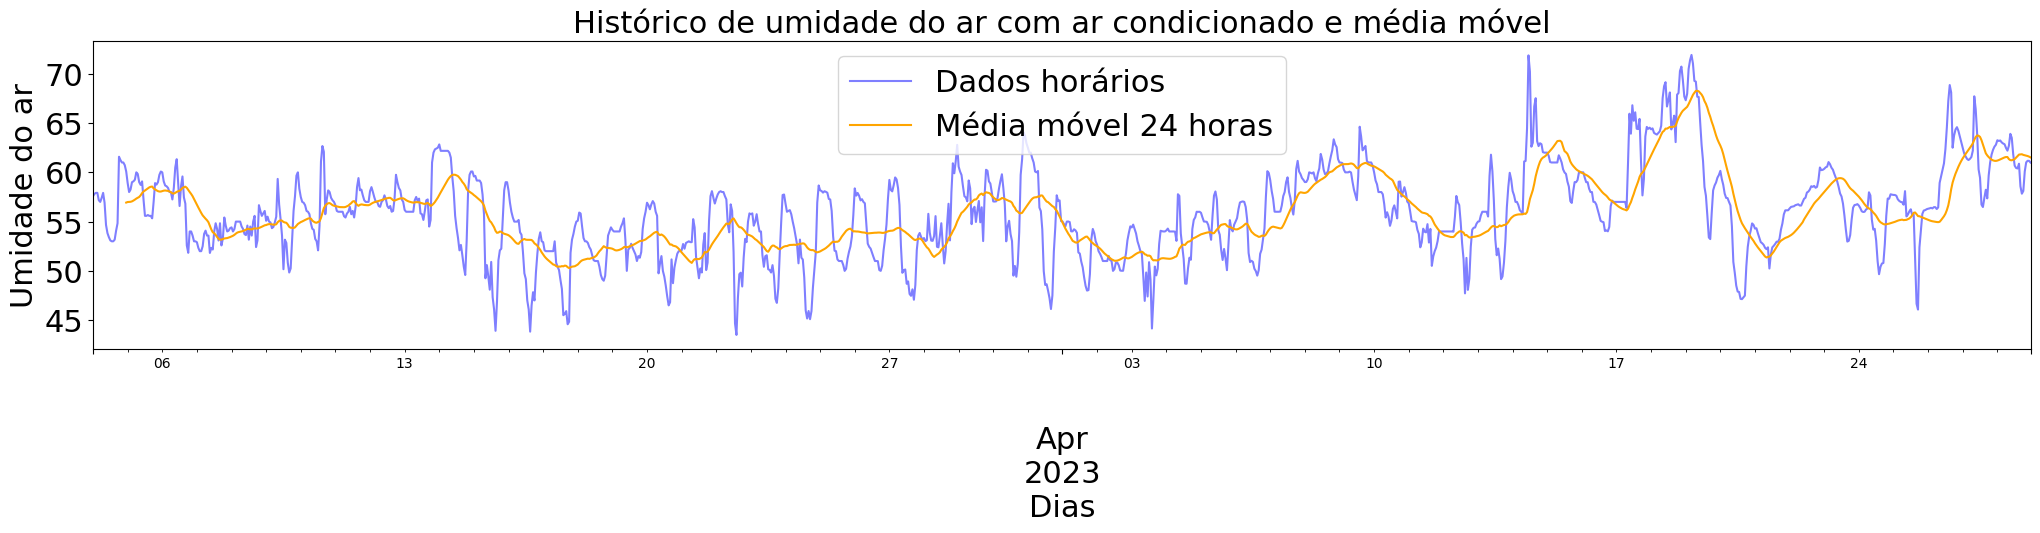

CPU times: user 1.28 s, sys: 47.7 ms, total: 1.32 s
Wall time: 1.33 s


In [65]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

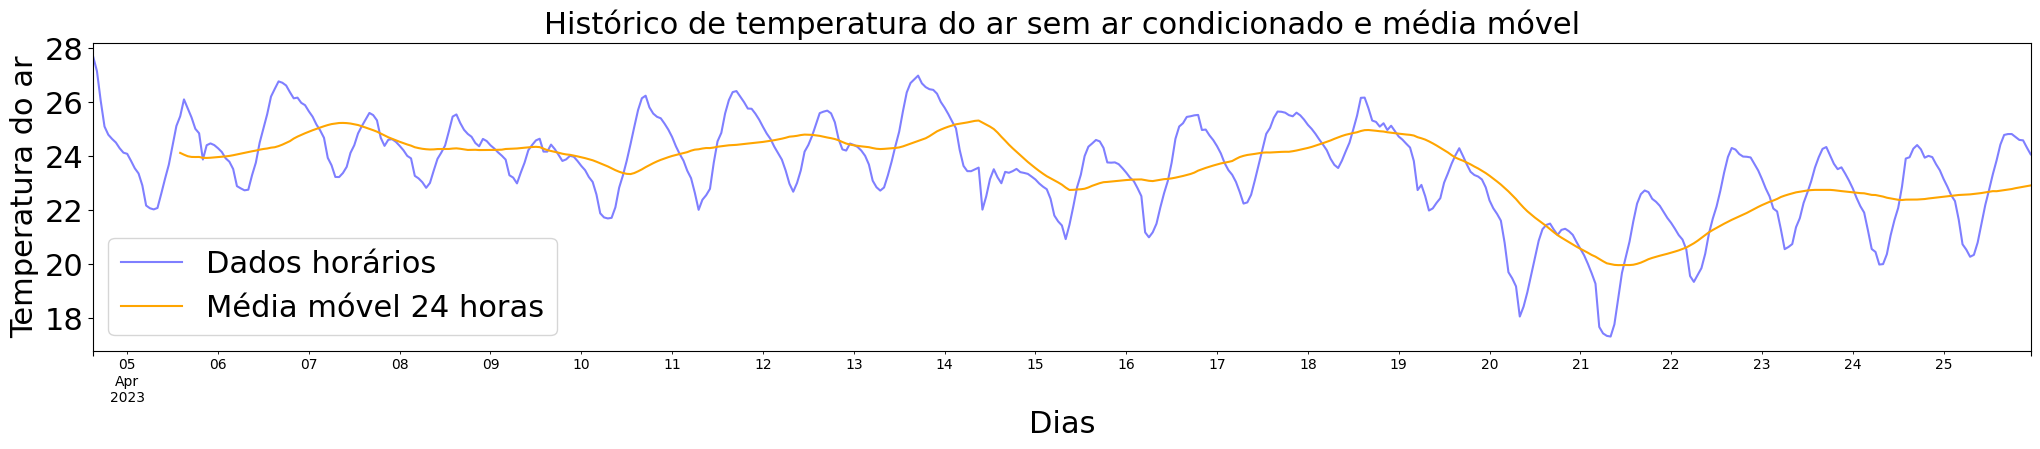

CPU times: user 661 ms, sys: 38.7 ms, total: 699 ms
Wall time: 716 ms


In [66]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

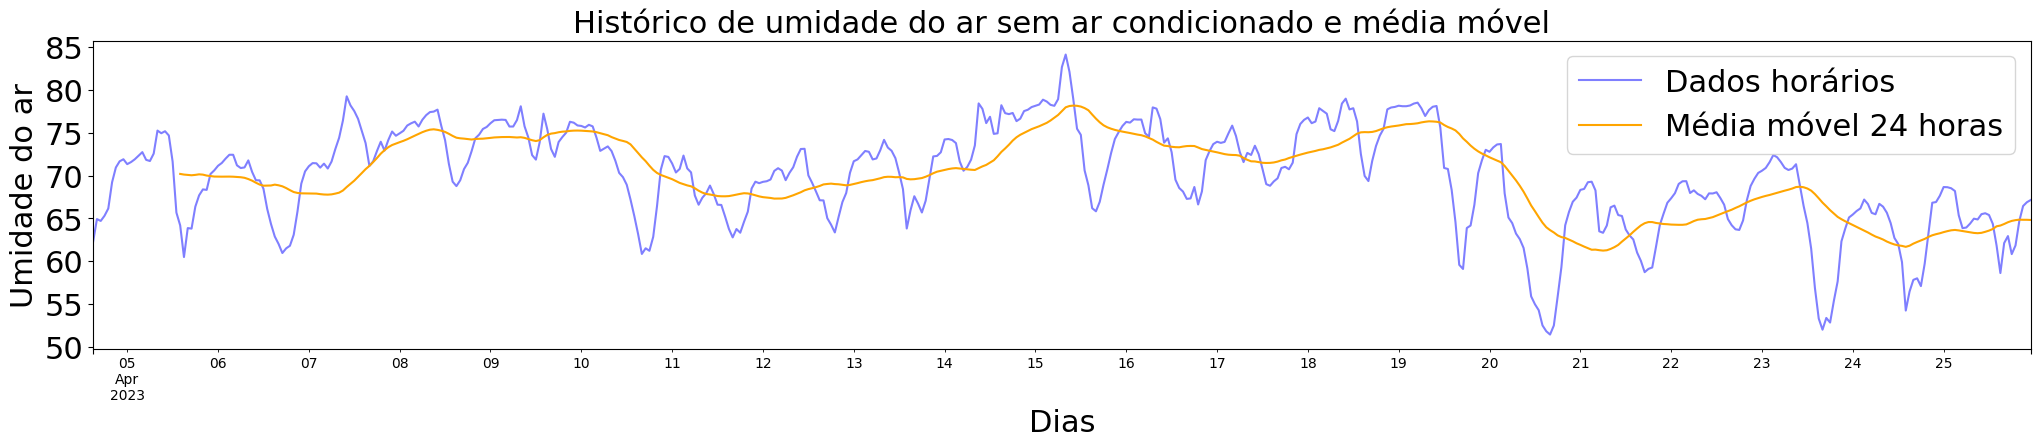

CPU times: user 640 ms, sys: 47.5 ms, total: 687 ms
Wall time: 764 ms


In [67]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

# Feature engineering

Criando features com dados das últimas t horas passadas

In [68]:
horas_passadas = 24

In [69]:
def constroi_features_defasadas(base,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    base_cop = base.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            base_cop[str(feat)+'_def_'+str(i)] = base_cop[feat].shift(i)
    return base_cop

In [70]:
%%time
dados_agrupados_minutos_semar_eng = constroi_features_defasadas(dados_agrupados_minutos_semar,['temp_ar','umid_ar'],horas_passadas)
dados_agrupados_minutos_comar_eng = constroi_features_defasadas(dados_agrupados_minutos_comar,['temp_ar','umid_ar'],horas_passadas)

CPU times: user 59.6 ms, sys: 2.02 ms, total: 61.6 ms
Wall time: 61 ms


In [71]:
dados_agrupados_minutos_semar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

In [72]:
dados_agrupados_minutos_comar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

Criando features com dados das próximas t horas

In [73]:
proximas_horas = 12

In [74]:
def construcao_target(base,nome_feature_target,periodos_considerados):
    # Constrói a variável resposta usando feature_target agrupado pelo número periodos_considerados
    cols_target = []
    for i in range(periodos_considerados):
        nome_feature = nome_feature_target+'_'+str(i)
        cols_target.append(nome_feature)
        base[nome_feature] = base[nome_feature_target].shift(-i)
    # Consolidação final
    base['target'] = base[cols_target].mean(axis=1)
    # Retorna a base apenas com a coluna target, desconsiderando as demais
    return base.drop(cols_target,axis=1)

In [75]:
%%time
dados_agrupados_minutos_comar_eng = construcao_target(dados_agrupados_minutos_comar_eng,'temp_ar',12).dropna()
dados_agrupados_minutos_semar_eng = construcao_target(dados_agrupados_minutos_semar_eng,'temp_ar',12).dropna()

CPU times: user 29.4 ms, sys: 1.94 ms, total: 31.4 ms
Wall time: 32.5 ms


In [76]:
dados_agrupados_minutos_comar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

In [77]:
dados_agrupados_minutos_semar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

# Features de sazonalidade

In [78]:
%%time
''' dados_agrupados_minutos_semar_eng['mes'] = dados_agrupados_minutos_semar_eng.index.month '''
dados_agrupados_minutos_semar_eng['dia_da_semana'] = dados_agrupados_minutos_semar_eng.index.dayofweek

''' dados_agrupados_minutos_comar_eng['mes'] = dados_agrupados_minutos_comar_eng.index.month '''
dados_agrupados_minutos_comar_eng['dia_da_semana'] = dados_agrupados_minutos_comar_eng.index.dayofweek

CPU times: user 2.78 ms, sys: 0 ns, total: 2.78 ms
Wall time: 2.84 ms


In [79]:
dados_agrupados_minutos_semar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

In [80]:
dados_agrupados_minutos_comar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

# Separando features e target

In [81]:
%%time
X_comar = dados_agrupados_minutos_comar_eng.drop('temp_ar',axis=1)
y_comar = dados_agrupados_minutos_comar_eng.temp_ar

X_semar = dados_agrupados_minutos_semar_eng.drop('temp_ar',axis=1)
y_semar = dados_agrupados_minutos_semar_eng.temp_ar

CPU times: user 3.03 ms, sys: 0 ns, total: 3.03 ms
Wall time: 4.49 ms


In [82]:
X_comar.head()

,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar,temp_ar_def_1,temp_ar_def_2,temp_ar_def_3,temp_ar_def_4,temp_ar_def_5,temp_ar_def_6,temp_ar_def_7,...,umid_ar_def_17,umid_ar_def_18,umid_ar_def_19,umid_ar_def_20,umid_ar_def_21,umid_ar_def_22,umid_ar_def_23,umid_ar_def_24,target,dia_da_semana
data,,,,,,,,,,,,,,,,,,,,,
2023-03-05 00:00:00,58.92,26.59,56.99,26.40,26.40,26.46,26.51,26.60,26.71,26.72,...,57.92,57.42,57.00,57.17,57.92,57.92,57.82,57.58,26.28,6
2023-03-05 01:00:00,58.00,26.58,57.00,26.40,26.40,26.40,26.46,26.51,26.60,26.71,...,56.92,57.92,57.42,57.00,57.17,57.92,57.92,57.82,26.28,6
2023-03-05 02:00:00,58.25,26.57,57.01,26.40,26.40,26.40,26.40,26.46,26.51,26.60,...,54.67,56.92,57.92,57.42,57.00,57.17,57.92,57.92,26.28,6
2023-03-05 03:00:00,59.00,26.56,57.05,26.35,26.40,26.40,26.40,26.40,26.46,26.51,...,53.83,54.67,56.92,57.92,57.42,57.00,57.17,57.92,26.28,6
2023-03-05 04:00:00,59.08,26.55,57.13,26.30,26.35,26.40,26.40,26.40,26.40,26.46,...,53.42,53.83,54.67,56.92,57.92,57.42,57.00,57.17,26.30,6


In [83]:
y_comar.head()

data
2023-03-05 00:00:00   26.40
2023-03-05 01:00:00   26.40
2023-03-05 02:00:00   26.35
2023-03-05 03:00:00   26.30
2023-03-05 04:00:00   26.29
Freq: 60T, Name: temp_ar, dtype: float64

In [84]:
X_semar.head()

,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar,temp_ar_def_1,temp_ar_def_2,temp_ar_def_3,temp_ar_def_4,temp_ar_def_5,temp_ar_def_6,temp_ar_def_7,...,umid_ar_def_17,umid_ar_def_18,umid_ar_def_19,umid_ar_def_20,umid_ar_def_21,umid_ar_def_22,umid_ar_def_23,umid_ar_def_24,target,dia_da_semana
data,,,,,,,,,,,,,,,,,,,,,
2023-04-05 15:00:00,60.49,24.04,70.12,25.47,25.11,24.39,23.68,23.16,22.60,22.07,...,71.67,70.94,69.22,66.15,65.30,64.70,64.92,62.30,24.71,2
2023-04-05 16:00:00,63.87,23.99,70.07,26.09,25.47,25.11,24.39,23.68,23.16,22.60,...,71.91,71.67,70.94,69.22,66.15,65.30,64.70,64.92,24.52,2
2023-04-05 17:00:00,63.81,23.96,70.04,25.75,26.09,25.47,25.11,24.39,23.68,23.16,...,71.33,71.91,71.67,70.94,69.22,66.15,65.30,64.70,24.33,2
2023-04-05 18:00:00,66.37,23.96,70.08,25.42,25.75,26.09,25.47,25.11,24.39,23.68,...,71.57,71.33,71.91,71.67,70.94,69.22,66.15,65.30,24.12,2
2023-04-05 19:00:00,67.69,23.96,70.14,25.00,25.42,25.75,26.09,25.47,25.11,24.39,...,71.90,71.57,71.33,71.91,71.67,70.94,69.22,66.15,23.94,2


In [85]:
y_semar.head()

data
2023-04-05 15:00:00   26.09
2023-04-05 16:00:00   25.75
2023-04-05 17:00:00   25.42
2023-04-05 18:00:00   25.00
2023-04-05 19:00:00   24.84
Freq: 60T, Name: temp_ar, dtype: float64

# Conjuntos de treino e teste

Nosso conjunto de teste será de 5 dias

In [86]:
%%time
corte_treino_teste = '2023-04-24 00:00:00'

X_train_comar = X_comar[X_comar.index < corte_treino_teste]
X_test_comar = X_comar[X_comar.index >= corte_treino_teste]
X_train_semar = X_semar[X_semar.index < corte_treino_teste]
X_test_semar = X_semar[X_semar.index >= corte_treino_teste]

y_train_comar = y_comar[y_comar.index < corte_treino_teste]
y_test_comar = y_comar[y_comar.index >= corte_treino_teste]
y_train_semar = y_semar[y_semar.index < corte_treino_teste]
y_test_semar = y_semar[y_semar.index >= corte_treino_teste]

print('Tamanho do treino com ar condicionado '+str(len(X_train_comar)))
print('Tamanho do teste com ar condicionado '+str(len(X_test_comar)))
print('Tamanho do treino com ar condicionado '+str(len(X_train_semar)))
print('Tamanho do teste com ar condicionado '+str(len(X_test_semar)))

Tamanho do treino com ar condicionado 1200
Tamanho do teste com ar condicionado 120
Tamanho do treino com ar condicionado 441
Tamanho do teste com ar condicionado 48
CPU times: user 6.3 ms, sys: 0 ns, total: 6.3 ms
Wall time: 6.57 ms


# Crossvalidação em séries temporais

Visualizando crossvalidação nas séries temporais

In [87]:
%%time
from sklearn.model_selection import TimeSeriesSplit

ts_semar = TimeSeriesSplit(n_splits=5).split(X_train_semar,y_train_semar)
ts_semar

ts_comar = TimeSeriesSplit(n_splits=5).split(X_train_comar,y_train_comar)
ts_comar

CPU times: user 72 µs, sys: 8 µs, total: 80 µs
Wall time: 85.6 µs


<generator object TimeSeriesSplit.split at 0x7f2af904e500>

Tamanho de cada fold geraco com TimeSeriesSplit

In [88]:
%%time
i=1
for train_index_semar, test_index_semar in TimeSeriesSplit(n_splits=5).split(X_train_semar,y_train_semar):
    #print(train_index)
    print('Fold '+str(i))
    print('Conjunto de treino: '+str(len(X_semar.iloc[train_index_semar]))+' registros')
    print('Conjunto de teste: '+str(len(X_semar.iloc[test_index_semar]))+' registros')
    print('---')
    i = i+1

Fold 1
Conjunto de treino: 76 registros
Conjunto de teste: 73 registros
---
Fold 2
Conjunto de treino: 149 registros
Conjunto de teste: 73 registros
---
Fold 3
Conjunto de treino: 222 registros
Conjunto de teste: 73 registros
---
Fold 4
Conjunto de treino: 295 registros
Conjunto de teste: 73 registros
---
Fold 5
Conjunto de treino: 368 registros
Conjunto de teste: 73 registros
---
CPU times: user 14.9 ms, sys: 991 µs, total: 15.9 ms
Wall time: 19.9 ms


In [89]:
%%time
i=1
for train_index_comar, test_index_comar in TimeSeriesSplit(n_splits=5).split(X_train_comar,y_train_comar):
    #print(train_index)
    print('Fold '+str(i))
    print('Conjunto de treino: '+str(len(X_comar.iloc[train_index_comar]))+' registros')
    print('Conjunto de teste: '+str(len(X_comar.iloc[test_index_comar]))+' registros')
    print('---')
    i = i+1

Fold 1
Conjunto de treino: 200 registros
Conjunto de teste: 200 registros
---
Fold 2
Conjunto de treino: 400 registros
Conjunto de teste: 200 registros
---
Fold 3
Conjunto de treino: 600 registros
Conjunto de teste: 200 registros
---
Fold 4
Conjunto de treino: 800 registros
Conjunto de teste: 200 registros
---
Fold 5
Conjunto de treino: 1000 registros
Conjunto de teste: 200 registros
---
CPU times: user 10.9 ms, sys: 3 µs, total: 11 ms
Wall time: 10.8 ms


# Métrica utilizada para escolher o melhor modelo

Será utilizada a mean_absolute_error (MSE), que é a média das diferenças entre a variável verdadeira e a predita em módulo. O objetivo é encontrar o modelo com menor MAE.

In [90]:
modelos_candidatos = {'Árvore':DecisionTreeRegressor(max_depth=5),
                      'RandomForest':RandomForestRegressor(max_depth=5),
                      'LGBM':LGBMRegressor(max_depth=5)
                     }

In [97]:
%%time
avaliacao_comar = {}
for nome_comar,model_comar in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model_comar, # Escolhendo o nosso modelo da vez
                            X_train_comar, y_train_comar, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=5), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                           n_jobs=8 # Número de processadores, para ser mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao_comar[nome_comar] = -score # -score e não score para tornar o número positivo

CPU times: user 89.4 ms, sys: 7.5 ms, total: 96.9 ms
Wall time: 5.78 s


In [98]:
%%time
avaliacao_semar = {}
for nome_semar,model_semar in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model_semar, # Escolhendo o nosso modelo da vez
                            X_train_semar, y_train_semar, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=5), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                           n_jobs=8 # Número de processadores, para ser mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao_semar[nome_semar] = -score # -score e não score para tornar o número positivo

CPU times: user 67.4 ms, sys: 6.74 ms, total: 74.2 ms
Wall time: 2.74 s


Comparando métricas de erros dos modelos

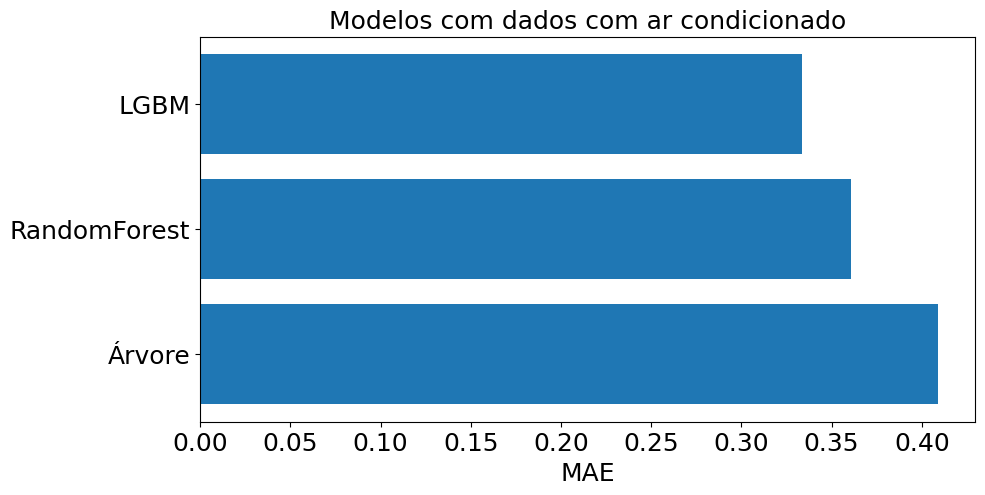

CPU times: user 220 ms, sys: 110 ms, total: 330 ms
Wall time: 219 ms


In [101]:
%%time
plt.figure(figsize=(10,5))
plt.barh(*zip(*avaliacao_comar.items()))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Modelos com dados com ar condicionado',size=18)
plt.xlabel('MAE',size=18)
plt.show()

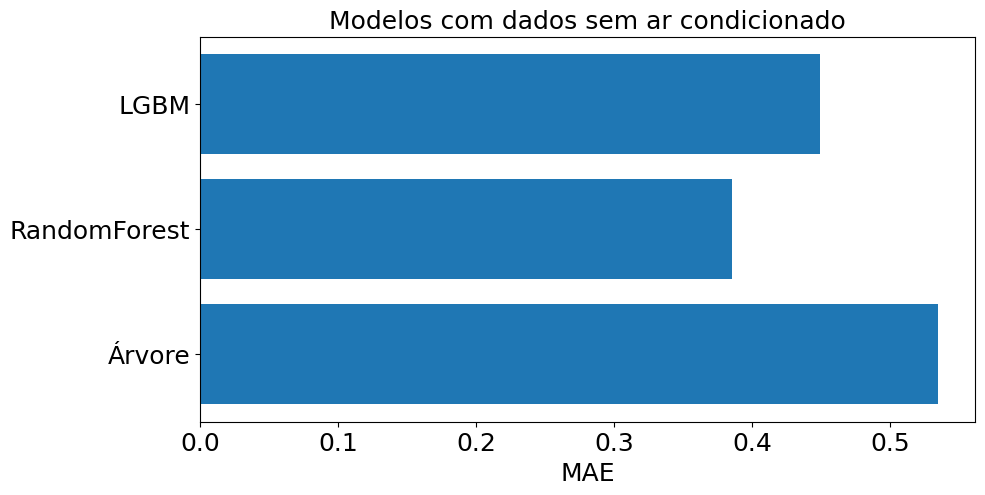

In [102]:
plt.figure(figsize=(10,5))
plt.barh(*zip(*avaliacao_semar.items()))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Modelos com dados sem ar condicionado',size=18)
plt.xlabel('MAE',size=18)
plt.show()